## Aggregate dynamics, stationary distribution and GE of a life-cycle economy

- author: Tao Wang
- this is a companion notebook to the paper ["Perceived income risks"](https://github.com/iworld1991/PIR/blob/master/PIR.pdf)

In [1]:
from psutil import Process 

In [2]:
import numpy as np
import pandas as pd
from interpolation import interp, mlinterp
from numba import njit
from numba.typed import List
import matplotlib as mp
import matplotlib.pyplot as plt
%matplotlib inline
from time import time
from Utility import make_grid_exp_mult
import scipy.optimize as op
from matplotlib import cm
import joypy
from copy import copy
from Utility import cal_ss_2markov,lorenz_curve, gini
from Utility import mean_preserving_spread
from Utility import jump_to_grid,jump_to_grid_fast,gen_tran_matrix,gen_tran_matrix_fast
import pickle
from scipy import sparse 

In [3]:
## figure plotting configurations


plt.style.use('seaborn')
plt.rcParams["font.family"] = "Times New Roman" #'serif'
plt.rcParams['font.serif'] = 'Ubuntu'
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['axes.labelweight'] = 'bold'

## Set the 
plt.rc('font', size=25)
# Set the axes title font size
plt.rc('axes', titlesize=20)
# Set the axes labels font size
plt.rc('axes', labelsize=20)
# Set the font size for x tick labels
plt.rc('xtick', labelsize=20)
# Set the font size for y tick labels
plt.rc('ytick', labelsize=20)
# Set the legend font size
plt.rc('legend', fontsize=20)
# Set the font size of the figure title
plt.rc('figure', titlesize=20)

### The Life-cycle Model Class and the Solver

In [4]:
from SolveLifeCycle import LifeCycle, solve_model_backward_iter,compare_2solutions

## LifeCycle is a class for solving life-cycle consumption/saving problems 

### Initialize the model

In [5]:
from PrepareParameters import life_cycle_paras_q as lc_paras_Q
from PrepareParameters import life_cycle_paras_y as lc_paras_Y
## make a copy of the imported parameters 
lc_paras_y = copy(lc_paras_Y)
lc_paras_q = copy(lc_paras_Q)

In [6]:
print(lc_paras_y)

{'ρ': 2.0, 'β': 0.98, 'P': array([[0.18, 0.82],
       [0.04, 0.96]]), 'z_val': array([0., 1.]), 'σ_ψ': 0.15, 'σ_θ': 0.15, 'U': 0.0, 'LivPrb': 0.99375, 'R': 1.01, 'W': 1.0, 'T': 40, 'L': 60, 'G': array([1.02955663, 1.02707112, 1.02472198, 1.02250445, 1.02041411,
       1.01844633, 1.01659667, 1.01486087, 1.01323462, 1.01171374,
       1.01029408, 1.00897133, 1.00774169, 1.0066011 , 1.00554514,
       1.00457048, 1.00367308, 1.00284863, 1.00209379, 1.00140452,
       1.00077689, 1.00020754, 0.99969214, 0.99922734, 0.99880946,
       0.99843448, 0.99809891, 0.99779904, 0.99753112, 0.99729151,
       0.99707657, 0.9968825 , 0.99670583, 0.99654275, 0.99638963,
       0.996243  , 0.99609894, 0.99595392, 0.99580437, 0.99564648,
       0.81734119, 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ])

Text(0, 0.5, '$\\hat Y$')

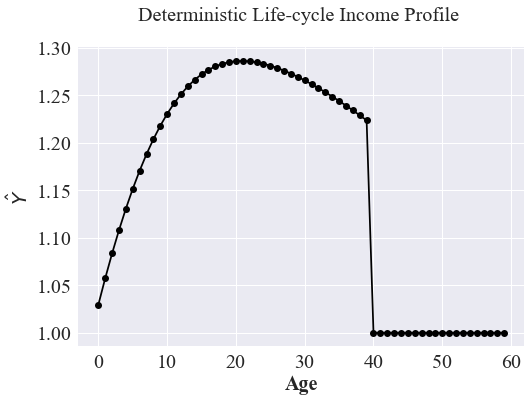

In [7]:
## a deterministic income profile 

## income profile 
YPath = np.cumprod(lc_paras_y['G'])

plt.title('Deterministic Life-cycle Income Profile \n')
plt.plot(YPath,'ko-')
plt.xlabel('Age')
plt.ylabel(r'$\hat Y$')

### Solve the model with a Markov state: unemployment and employment 

In [9]:
## initialize a class of life-cycle model with either calibrated or test parameters 

#################################
calibrated_model = True
model_frequency = 'yearly'
#################################

if calibrated_model == True:

    if model_frequency=='yearly':
        ## yearly parameters 

        lc_paras = lc_paras_y

    elif model_frequency=='quarterly':
        ## yearly parameters 
        lc_paras = lc_paras_q

    lc_mkv_paras = { 
        ## primitives
                   'ρ':lc_paras['ρ'],     ## relative risk aversion  
                   'β':lc_paras['β'],     ## discount factor
                   'borrowing_cstr':True,
                   'adjust_prob':1.0,
        
        ## prices 
                   'R':lc_paras['R'],           ## interest factor
                   'W':lc_paras['W'],           ## Wage rate
        
        ## life cycle 
                   'T':lc_paras['T'],
                   'L':lc_paras['L'],
                   'G':lc_paras['G'],
                   'LivPrb':lc_paras['LivPrb'],       ## living probability 
        
        ## income risks 
                   'x':0.0,
                   'b_y':0.0,
                   'sigma_psi':lc_paras['σ_ψ'],
                   'sigma_eps':lc_paras['σ_θ'],
                   'ue_markov':True,
                   'P':lc_paras['P'],
                   'U':lc_paras['U'],
                   'z_val':lc_paras['z_val'], ## markov state from low to high 
                   'sigma_psi_2mkv':lc_paras['σ_ψ_2mkv'],  ## permanent risks in 2 markov states
                   'sigma_eps_2mkv':lc_paras['σ_θ_2mkv'],  ## transitory risks in 2 markov states
                   'sigma_psi_true':lc_paras['σ_ψ'], ## true permanent
                   'sigma_eps_true':lc_paras['σ_θ'], ## true transitory
        
        ## initial conditions 
                    'sigma_p_init':lc_paras['σ_ψ_init'],
                    'init_b':lc_paras['init_b'],

        ## policy 
                   'unemp_insurance':lc_paras['unemp_insurance'],
                   'pension':lc_paras['pension'], ## pension
                   'λ':lc_paras['λ'],  ## tax rate
                   'λ_SS':lc_paras['λ_SS'], ## social tax rate
                   'transfer':lc_paras['transfer'],  ## transfer 
                   'bequest_ratio':lc_paras['bequest_ratio'],
         ## solutions 
                   'shock_draw_size':10.0,
                   'grid_max':10,
        
        ## bequest motives
        ######################
                   'q': 1.0,
                   'ρ_b':lc_paras['ρ'] ## homothetic bequest motive
        #######################
                    }
    
    ## initialize the model with calibrated parameters 
    
    lc_mkv = LifeCycle(**lc_mkv_paras)    
    
    ## for the subjective model, only change the belief 
    lc_mkv_sub_paras = copy(lc_mkv_paras)
    lc_mkv_sub_paras['subjective'] = True 
    lc_mkv_sub_paras['sigma_psi'] = lc_paras['σ_ψ_sub']
    lc_mkv_sub_paras['sigma_eps'] = lc_paras['σ_θ_sub']
    lc_mkv_sub = LifeCycle(**lc_mkv_sub_paras)
        
    
     ## for the subjective-true model, let the true parameters to be same as the belief 
        
    lc_mkv_sub_true_paras = copy(lc_mkv_sub_paras)
    lc_mkv_sub_true_paras['subjective'] = False
    lc_mkv_sub_true_paras['sigma_psi_true'] = lc_paras['σ_ψ_sub']
    lc_mkv_sub_true_paras['sigma_eps_true'] =  lc_paras['σ_θ_sub']
    #lc_mkv_sub_true_paras['sigma_p_init'] = np.sqrt(lc_paras['σ_ψ_init']**2+ 0.6**2)

    lc_mkv_sub_true = LifeCycle(**lc_mkv_sub_true_paras)

reminder: needs to give true risk parameters: sigma_psi_true & sigma_eps_true!


In [10]:
## solve various models

models = [lc_mkv,
          lc_mkv_sub,
          lc_mkv_sub_true,
          ]
specs = ['ob',
         'sub',
         'sub_true',
         ]

model_names=['baseline',
             'SLPR',
             'LPR',
             ]

ms_stars = []
σs_stars = []

t_start = time()
for i, model in enumerate(models):
    ## terminal solution
    m_init,σ_init = model.terminal_solution()

    ## solve backward
    if specs[i]!='cr':
        ms_star, σs_star = solve_model_backward_iter(model,
                                                     m_init,
                                                     σ_init)
    else:
        ms_star, σs_star = solve_model_backward_iter(model,
                                                     m_init,
                                                     σ_init,
                                                     sv = True)
    ms_stars.append(ms_star)
    σs_stars.append(σs_star)

t_finish = time()

print("Time taken, in seconds: "+ str(t_finish - t_start))


Time taken, in seconds: 2.773669719696045


In [11]:
## be careful with the order 
## get the solution for the objective model 
ms_star_mkv, σs_star_mkv = ms_stars[0],σs_stars[0]

## get the solution for the subjective model 
ms_star_mkv_sub,σs_star_mkv_sub = ms_stars[1],σs_stars[1]

should be NEGATIVE!!!!!


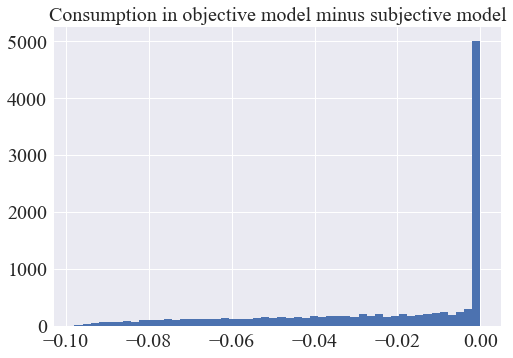

In [12]:
## compare different models 

ojb_minus_sub = compare_2solutions(ms_stars[0:2],
                                   σs_stars[0:2])

plt.hist(ojb_minus_sub.flatten(),
         bins=50)
plt.title('Consumption in objective model minus subjective model')
print('should be NEGATIVE!!!!!')

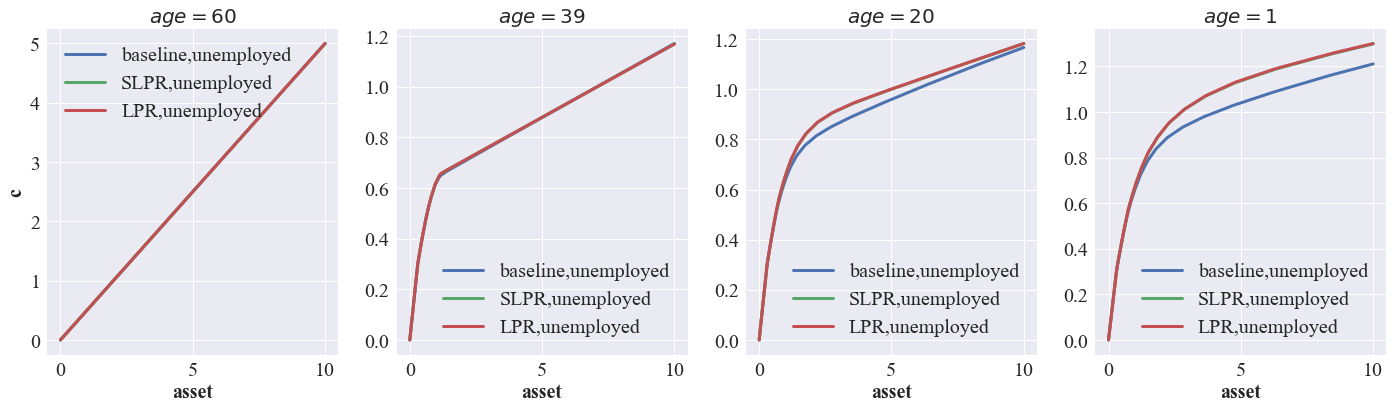

In [13]:
## compare solutions 

m_grid = np.linspace(0.0,10.0,200)
## plot c func at different age /asset grid
years_left = [0,21,40,59]

n_sub = len(years_left)

eps_fix = 0 ## the first eps grid 

fig,axes = plt.subplots(1,n_sub,figsize=(6*n_sub,6))

for x,year in enumerate(years_left):
    age = lc_mkv.L-year
    i = lc_mkv.L-age
    for k,model_name in enumerate(model_names):
        m_plt_u,c_plt_u = ms_stars[k][i,:,eps_fix,0],σs_stars[k][i,:,eps_fix,0]
        m_plt_e,c_plt_e = ms_stars[k][i,:,eps_fix,1],σs_stars[k][i,:,eps_fix,1]
        c_func_u = lambda m: interp(m_plt_u,c_plt_u,m)
        c_func_e = lambda m: interp(m_plt_e,c_plt_e,m)
        axes[x].plot(m_grid,
                     c_func_u(m_grid),
                     label = model_name+',unemployed',
                     lw=3
                    )
        #axes[x].plot(m_grid,
        #             c_func_e(m_grid),
        #             label = model_name+',employed',
        #             lw=3
        #            )
    axes[x].legend()
    #axes[x].set_xlim(0.0,np.max(m_plt_u))
    axes[x].set_xlabel('asset')
    axes[0].set_ylabel('c')
    axes[x].set_title(r'$age={}$'.format(age))

## Aggregate steady state distributions

In [14]:
from Utility import stationary_age_dist
## a function that computes social security tax rate balances gov budget for pension
from Utility import unemp_insurance2tax  
## a function that computes tax rate balances gov budget for ue insurance
from Utility import SS2tax
from Utility import CDProduction  
from PrepareParameters import production_paras_y as production_paras

In [15]:
#################################
## general functions used 
# for computing transition matrix
##################################

## compute the list of transition matrix from age t to t+1 for all age 

@njit
def calc_transition_matrix(model, 
                           ms_star, ## new,  life cycle age x asset x tran shock x z state grid 
                           σs_star, ## new, life cycle consumption t age  x asset x tran shock x z state grid
                           dist_mGrid_list, ## new, list, grid of m for distribution 
                           dist_pGrid_list,  ## new, list, grid of p for distribution 
                           fast = False   ## new
                          ):
        '''
        Calculates how the distribution of agents across market resources 
        transitions from one period to the next. 
        If finite horizon problem, then calculates
        a list of transition matrices, consumption and asset policy grids for each period of the problem. 
        
        
        Parameters
        ----------
            # ms_star: array, sized of T x n_a x n_eps x n_z, wealth grid 
            # σs_star: array, sized of T x n_a x n_eps x n_z, consumption values at the grid
            # dist_mGrid_list, list, sized of 1, list of m grid sized of n_m
            # dist_pGrid_list, list, sized of T, list of permanent income grid for each age, sized of n_p
            # fast, bool, fast or slow method 

        Returns
        -------
            # tran_matrix_list, numba typed list, embedded list, sized of n_z,
            ## each of which is sized of T, each of which is sized of n_m x n_p 
        
        ''' 

        ## unemployment insurance 
        unemp_insurance = model.unemp_insurance
        
        ## tax rate
        λ = model.λ
        λ_SS = model.λ_SS
        
        ## permanent income growth factor
        G = model.G
        
        ## grid holders
 
        aPol_Grid_e_list = [] # List of asset policy grids for each period in T_cycle
        aPol_Grid_u_list = [] # List of asset policy grids for each period in T_cycle
        
        
        tran_matrix_e_list = [] # List of transition matrices
        tran_matrix_u_list = [] # List of transition matrices
        

        #Obtain shocks and shock probabilities from income distribution in this period
        size_shk_probs  = len(model.eps_shk_true_draws)*len(model.psi_shk_true_draws)
        shk_prbs = np.ones(size_shk_probs)*1/size_shk_probs
        tran_shks = np.exp(np.repeat(model.eps_shk_true_draws,
                              len(model.psi_shk_true_draws)))
        perm_shks = np.exp(np.repeat(model.psi_shk_true_draws,
                              len(model.eps_shk_true_draws)))

        ## This is for the fast method 
        shk_prbs_ntrl =  np.multiply(shk_prbs,perm_shks)
                        
        
                        
        for k in range(model.L): ## loop over agents at different ages, k
            
            age_id = k
            age = age_id + 1
            year_left = model.L-age
            
            markov_array2 = model.P

            this_dist_pGrid = dist_pGrid_list[0] #If here then use prespecified permanent income grid
            ## m-grid does not depend on period             
            this_dist_mGrid = dist_mGrid_list[0]
        
            
            ## compute different c at different a and eps
            
            n_mgrid = len(this_dist_mGrid)
            
            Cnow_u= np.empty(n_mgrid,dtype = np.float64)
            Cnow_e = np.empty(n_mgrid,dtype = np.float64)

            fix_epsGrid = 1.0 ## can be anything because c is not a function of eps
            
            for m_id,m in enumerate(this_dist_mGrid):
                Cnow_u[m_id] = mlinterp((ms_star[year_left,:,0,0],   
                                        model.eps_grid),
                                       σs_star[year_left,:,:,0],
                                       (m,fix_epsGrid))
                
                Cnow_e[m_id] = mlinterp((ms_star[year_left,:,0,1],
                                        model.eps_grid),
                                       σs_star[year_left,:,:,1],
                                       (m,fix_epsGrid))
                
            
            ## more generally, depending on the nb of markov states 
        
            aNext_u = this_dist_mGrid - Cnow_u # Asset policy grid in each age
            aNext_e = this_dist_mGrid - Cnow_e # Asset policy grid in each age
            
            aPol_Grid_u_list.append(aNext_u) # Add to list
            aPol_Grid_e_list.append(aNext_e) # Add to list

            bNext_u = model.R*aNext_u
            bNext_e = model.R*aNext_e

            
            ## determine income process depending on emp/uemp| work/retirement
            if k <=model.T-1:
                ## work age 
                perm_shks_G_ef = perm_shks* G[k+1]
                tran_shks_ef_u = np.ones_like(tran_shks)*(model.transfer
                                                        +(1-λ)*unemp_insurance)
                tran_shks_ef_e = np.ones_like(tran_shks)*(model.transfer
                                                        +(1-λ)*(1-λ_SS)*tran_shks)

                #mNext_ij = bNext_u[i]/perm_shks_G +model.transfer+ (1-λ)*unemp_insurance # Compute next period's market resources given todays bank balances bnext[i]
            else:
                ## retirement
                perm_shks_G_ef = np.ones_like(perm_shks)*G[k+1]
                tran_shks_ef_u = np.ones_like(tran_shks)*(model.transfer
                                                        + model.pension)
                tran_shks_ef_e = tran_shks_ef_u

            if fast==True:
                print('warning: the fast method is not fully developed yet!!!')
            
                # Generate Transition Matrix for u2u
                TranMatrix_uu = gen_tran_matrix_fast(this_dist_mGrid, 
                                                     bNext_u, 
                                                     shk_prbs_ntrl,
                                                     perm_shks_G_ef,
                                                     tran_shks_ef_u)
                
                # Generate Transition Matrix for u2e
                TranMatrix_ue = gen_tran_matrix_fast(this_dist_mGrid, 
                                                     bNext_e, 
                                                     shk_prbs_ntrl,
                                                     perm_shks_G_ef,
                                                     tran_shks_ef_e)
            

                # Generate Transition Matrix for e2e 
                
                TranMatrix_ee = gen_tran_matrix_fast(this_dist_mGrid, 
                                                     bNext_e, 
                                                     shk_prbs_ntrl,
                                                     perm_shks_G_ef,
                                                     tran_shks_ef_e)
            

                # Generate Transition Matrix for e2u 
                 
                TranMatrix_eu = gen_tran_matrix_fast(this_dist_mGrid, 
                                                     bNext_u, 
                                                     shk_prbs_ntrl,
                                                     perm_shks_G_ef,
                                                     tran_shks_ef_u)


            else:  ## slow method  (2-state Markov implemented)

                    
                # Generate Transition Matrix for u2u 
                TranMatrix_uu = gen_tran_matrix(this_dist_mGrid,
                                               this_dist_pGrid,
                                               bNext_u,
                                               shk_prbs,
                                               perm_shks_G_ef,
                                               tran_shks_ef_u)
                
    
                # Generate Transition Matrix for u2e
                
                TranMatrix_ue = gen_tran_matrix(this_dist_mGrid,
                                               this_dist_pGrid,
                                               bNext_u,
                                               shk_prbs,
                                               perm_shks_G_ef,
                                               tran_shks_ef_e)

                        
                # Generate Transition Matrix for e2u 
                
                TranMatrix_eu = gen_tran_matrix(this_dist_mGrid,
                                               this_dist_pGrid,
                                                bNext_e,
                                               shk_prbs,
                                               perm_shks_G_ef,
                                               tran_shks_ef_u)
                        
                # Generate Transition Matrix for e2e 
                TranMatrix_ee = gen_tran_matrix(this_dist_mGrid,
                                               this_dist_pGrid,
                                               bNext_e,
                                               shk_prbs,
                                               perm_shks_G_ef,
                                               tran_shks_ef_e)
                        
        ###################################################
        ## back from the fork between slow and fast method 
        ##################################################
        ## transition matrix for each markov state 
            tran_matrix_u = markov_array2[0,1] * TranMatrix_ue  + markov_array2[0,0]* TranMatrix_uu #This is the transition for someone who's state today is unemployed
            tran_matrix_e = markov_array2[1,1]*TranMatrix_ee  +  markov_array2[1,0] * TranMatrix_eu # This is the transition for someone who's state is employed today

                
            ## merge to the life cycle list 
            tran_matrix_u_list.append( tran_matrix_u ) #This is the transition for someone who's state today is unemployed
            tran_matrix_e_list.append( tran_matrix_e )
            
                
        tran_matrix_list = List([tran_matrix_u_list,
                                 tran_matrix_e_list])
        
        ## return aggregate transition matrix and 
        ###.   the age/state dependent transition matrices necessary for computing aggregate consumption
        
        
        ## consumption policy and saving grid on each m, p, z and k grid 

        aPol_Grid_list = List([aPol_Grid_u_list,
                               aPol_Grid_e_list]) ## list of consumption 
        
        
        return tran_matrix_list, aPol_Grid_list #cPol_Grid_list

@njit
def initial_distribution_u(model,
                         dist_mGrid, ## new, array, grid of m for distribution 
                         dist_pGrid,  ## new, array, grid of p for distribution 
                        ):
    ## get the distribution of p after shocks 
    init_p_plus_shk_draws = np.sort(
        np.array(
            [np.exp(init_p) * np.exp(psi_shk) 
             for init_p in model.init_p_draws 
             for psi_shk in model.psi_shk_true_draws
            ]
        )
    )
    init_p_plus_shk_probs = np.ones(len(init_p_plus_shk_draws))/len(init_p_plus_shk_draws)
    shk_prbs = np.repeat(
        init_p_plus_shk_probs,
        len(model.eps_shk_true_draws)
    )*1/len(model.eps_shk_true_draws)
    
    λ = model.λ
    init_b = model.init_b
    ue_insurance = np.repeat(np.ones_like(model.eps_shk_true_draws),
                          len(init_p_plus_shk_probs))*model.unemp_insurance  
    init_p_draws = np.exp(np.repeat(init_p_plus_shk_draws,
                          len(model.eps_shk_true_draws)))
    
    ## this function starts with a state-specific initial distribution over m and p as a vector sized of (n_m x n_p) 
    NewBornDist = jump_to_grid(np.ones_like(init_p_draws)*((1-λ)*ue_insurance+init_b/init_p_draws+model.transfer), ## initial unemployment insurance and accidental bequest transfer
                               init_p_draws,
                               shk_prbs,
                               dist_mGrid,
                               dist_pGrid)
    return NewBornDist

@njit
def initial_distribution_e(model,
                         dist_mGrid, ## new, array, grid of m for distribution 
                         dist_pGrid,  ## new, array, grid of p for distribution 
                        ):
    ## get the distribution of p after shocks 
    init_p_plus_shk_draws = np.sort(
        np.array(
            [np.exp(init_p) * np.exp(psi_shk) 
             for init_p in model.init_p_draws 
             for psi_shk in model.psi_shk_true_draws
            ]
        )
    )
    init_p_plus_shk_probs = np.ones(len(init_p_plus_shk_draws))/len(init_p_plus_shk_draws)
    shk_prbs = np.repeat(
        init_p_plus_shk_probs,
        len(model.eps_shk_true_draws)
    )*1/len(model.eps_shk_true_draws)
    
    λ = model.λ
    λ_SS = model.λ_SS
    init_b = model.init_b
    
    tran_shks = np.exp(np.repeat(model.eps_shk_true_draws,
                          len(init_p_plus_shk_probs)))
    init_p_draws = np.exp(np.repeat(init_p_plus_shk_draws,
                          len(model.eps_shk_draws)))
    ## this function starts with a state-specific initial distribution over m and p as a vector sized of (n_m x n_p) 
    NewBornDist = jump_to_grid((1-λ)*(1-λ_SS)*tran_shks+init_b/init_p_draws+model.transfer,
                               ## initial transitory risks and accidental bequest transfer
                               init_p_draws,
                               shk_prbs,
                               dist_mGrid,
                               dist_pGrid)
    return NewBornDist

def AggregateDist(dist_lists,  ## size of nb markov state, each of which is sized model.L, each of which is sized n_m x n_p
              mp_pdfs_lists,  ## list of pdfs of over m and p grids given markov state and age
              mkv_dist, 
              age_dist):      ## distribution over ages
    X = 0.0
    for z in range(len(mkv_dist)):
        for k in range(len(age_dist)):
            x_flat = dist_lists[z][k].flatten()
            pdf_flat = mp_pdfs_lists[z][k].flatten()
            X+= np.dot(x_flat,pdf_flat)*age_dist[k]*mkv_dist[z]
    return X

## get the single vector of distribution 

def flatten_list(grid_lists,      ## nb.z x T x nb x nm x np 
                 mp_pdfs_lists,   ## nb.z x T x nb x nm x np 
                 dstn,            ## size of nb.z 
                 age_dist):       ## size of T 
    mp_pdfs_lists_new = []
    for z in range(len(dstn)):
        for k in range(len(age_dist)):
            this_pdfs_lists = mp_pdfs_lists[z][k]*dstn[z]*age_dist[k]
            mp_pdfs_lists_new.append(this_pdfs_lists)
            
    grid_sort_id = np.array(grid_lists).flatten().argsort()
    grid_array = np.array(grid_lists).flatten()[grid_sort_id]
    mp_pdfs_array = np.array(mp_pdfs_lists_new).flatten()[grid_sort_id]
    
    return grid_array, mp_pdfs_array


In [16]:
class HH_OLG_Markov:
    """
    A class that deals with distributions of the household (HH) block
    """

    def __init__(self,
                 model = None):  

        self.model = model
        
        self.age_dist = stationary_age_dist(model.L,
                                            n = 0.0,
                                            LivPrb = model.LivPrb)
        
        self.ss_dstn = cal_ss_2markov(model.P)
        
    ## create distribution grid points 
    def define_distribution_grid(self,
                                 dist_mGrid = None, 
                                 dist_pGrid = None, 
                                 m_density = 0, 
                                 num_pointsM = 40,  
                                 num_pointsP = 50, 
                                 max_m_fac = 100.0,
                                 max_p_fac = 20.0):

            '''
            Defines the grid on which the distribution is defined. Stores the grid of market resources and permanent income as attributes of self.
            Grid for normalized market resources and permanent income may be prespecified 
            as dist_mGrid and dist_pGrid, respectively. If not then default grid is computed based off given parameters.

            Parameters
            ----------
            dist_mGrid : np.array
                    Prespecified grid for distribution over normalized market resources

            dist_pGrid : np.array
                    Prespecified grid for distribution over permanent income. 

            m_density: float
                    Density of normalized market resources grid. Default value is mdensity = 0.
                    Only affects grid of market resources if dist_mGrid=None.

            num_pointsM: float
                    Number of gridpoints for market resources grid.

            num_pointsP: float
                     Number of gridpoints for permanent income. 
                     This grid will be exponentiated by the function make_grid_exp_mult.

            max_p_fac : float
                    Factor that scales the maximum value of permanent income grid. 
                    Larger values increases the maximum value of permanent income grid.

            Returns
            -------
            List(dist_mGrid): numba typed list, sized of 1, each of which is sized n_m
            List(dist_pGrid): numba typed list, sized of T, each of which is sized n_p
            '''  
            
            ## model
            
            model = self.model 
            
            ## m distribution grid 
            if dist_mGrid == None:
                aXtra_Grid = make_grid_exp_mult(ming = model.a_grid[0], 
                                                maxg = model.a_grid[-1]*max_m_fac, 
                                                ng = num_pointsM, 
                                                timestonest = 3) #Generate Market resources grid given density and number of points

                for i in range(m_density):
                    axtra_shifted = np.delete(aXtra_Grid,-1) 
                    axtra_shifted = np.insert(axtra_shifted, 0,1.00000000e-04)
                    dist_betw_pts = aXtra_Grid - axtra_shifted
                    dist_betw_pts_half = dist_betw_pts/2
                    new_A_grid = axtra_shifted + dist_betw_pts_half
                    aXtra_Grid = np.concatenate((aXtra_Grid,new_A_grid))
                    aXtra_Grid = np.sort(aXtra_Grid)

                dist_mGrid =  [aXtra_Grid]

            else:
                dist_mGrid = [dist_mGrid] #If grid of market resources prespecified then use as mgrid

            ## permanent distribution grid 
            if dist_pGrid == None:
                dist_pGrid = [] #list of grids of permanent income    

                for i in range(model.L):
                    #Dist_pGrid is taken to cover most of the ergodic distribution
                    if model.sigma_psi!=0.0:
                        std_p = model.sigma_psi
                    else:
                        std_p = 1e-2
                    max_p = max_p_fac*std_p*(1/(1-model.LivPrb))**0.5 # Consider probability of staying alive this period
                    right_sided_grid = make_grid_exp_mult(1.05+1e-3, np.exp(max_p), num_pointsP, 2)
                    left_sided_gird = np.append(1.0/np.fliplr([right_sided_grid])[0],np.ones(1))
                    left_sided_gird = 1.0/np.fliplr([right_sided_grid])[0]
                    this_dist_pGrid = np.append(left_sided_gird,
                                                right_sided_grid) # Compute permanent income grid this period. Grid of permanent income may differ dependent on PermShkStd
                    dist_pGrid.append(this_dist_pGrid)

            else:
                dist_pGrid = [dist_pGrid] #If grid of permanent income prespecified then use as pgrid
                
            self.m_dist_grid_list = List(dist_mGrid)
            self.p_dist_grid_list = List(dist_pGrid)        
            
    ## get the distributions of each age by iterating forward over life cycle 

    def ComputeSSDist(self,
              ms_star = None,
              σs_star = None):
     
        model = self.model
        m_dist_grid_list = self.m_dist_grid_list
        p_dist_grid_list = self.p_dist_grid_list
        ss_dstn = self.ss_dstn
        age_dist = self.age_dist
        
        time_start = time()

        ## get the embedded list sized n_z x T x n_m x n_p
        tran_matrix_lists, a_PolGrid_list = calc_transition_matrix(model, 
                                                                   ms_star, ## 
                                                                 σs_star,
                                                                 m_dist_grid_list,
                                                                 p_dist_grid_list,
                                                                 fast = False)
        
        # storing as sparse matrix
        tran_matrix_lists = [[sparse.csr_matrix(tran_matrix_lists[0][i]) 
                              for i in range(len(tran_matrix_lists[0]))],
                             [sparse.csr_matrix(tran_matrix_lists[1][i]) 
                              for i in range(len(tran_matrix_lists[1]))]
                            ]
        
        ## save the output into the model 
        self.tran_matrix_lists = tran_matrix_lists
        
        ## the initial distribution in the first period of life 
        initial_dist_u = initial_distribution_u(model,
                                              m_dist_grid_list[0],
                                              p_dist_grid_list[0])

        initial_dist_e = initial_distribution_e(model,
                                                m_dist_grid_list[0],
                                                p_dist_grid_list[0])
        
        self.initial_dist_u = initial_dist_u
        self.initial_dist_e = initial_dist_e


        ## iterate forward 

        dist_u_lists = []
        dist_e_lists = []
        dist_u_lists.append(initial_dist_u)
        dist_e_lists.append(initial_dist_e)



        ## policy grid lists 
        ap_u_PolGrid_list = []
        ap_e_PolGrid_list = []


        ## m/p distribution in the first period in life (newborns)
        this_dist_u = initial_dist_u
        this_dist_e = initial_dist_e


        ## iterate forward for all periods in life 
       
        
        for k in range(model.L-1): ## no transition matrix in the last period !
            
            ## uemp 
            this_dist_u = tran_matrix_lists[0][k]@this_dist_u
            dist_u_lists.append(this_dist_u)
            

            ##emp
            this_dist_e = tran_matrix_lists[1][k]@this_dist_e
            dist_e_lists.append(this_dist_e)
            
            
        ## stack the distribution lists 
        dist_lists = [dist_u_lists,
                     dist_e_lists]
                    
        ## get level of a over life cycle 
        ap_u_PolGrid_list = [np.multiply.outer(a_PolGrid_list[0][k],
                                           p_dist_grid_list[k]).flatten() for k in range(model.L)]
        ap_e_PolGrid_list = [np.multiply.outer(a_PolGrid_list[1][k],
                                           p_dist_grid_list[k]).flatten() for k in range(model.L)]
   

        # a policy grid 
        ap_PolGrid_list = [ap_u_PolGrid_list,
                          ap_e_PolGrid_list]
        
        
        ## get the normalized a over life cycle 
        ap_ratio_u_PolGrid_list = [np.repeat(a_PolGrid_list[0][k],
                                           len(p_dist_grid_list[k])) for k in range(model.L)]
        ap_eratio_e_PolGrid_list = [np.repeat(a_PolGrid_list[1][k],
                                           len(p_dist_grid_list[k])) for k in range(model.L)]
        
        # a policy grid 
        ap_ratio_PolGrid_list = [ap_ratio_u_PolGrid_list,
                                 ap_eratio_e_PolGrid_list]

        
        time_end = time()
        print('time taken to get SS dist:'+str(time_end-time_start))
        
        memory = Process().memory_info().rss/1024/1024/1024
        print('memory usage: '+str(memory))
        
        self.dist_lists = dist_lists
        self.ap_PolGrid_list = ap_PolGrid_list
        ## also store flatten list of level of a and c
        self.ap_grid_dist, self.ap_pdfs_dist = flatten_list(ap_PolGrid_list,
                                                            dist_lists,
                                                            ss_dstn,
                                                            age_dist)
        
        ## stroe wealth to permanent income ratio distribution 
        
        self.a_grid_dist,self.a_pdfs_dist = flatten_list(ap_ratio_PolGrid_list,
                                                        dist_lists,
                                                        ss_dstn,
                                                        age_dist)
    ### Aggregate C or A

    def Aggregate(self):
        ## compute aggregate A 
        ap_PolGrid_list = self.ap_PolGrid_list
        dist_lists = self.dist_lists
        ss_dstn = self.ss_dstn
        age_dist = self.age_dist

        self.A = AggregateDist(ap_PolGrid_list,
                              dist_lists,
                              ss_dstn,
                              age_dist)

    ### Aggregate within age 
    
    def AggregatebyAge(self):
        
        model = self.model 
        
        ap_PolGrid_list = self.ap_PolGrid_list
        dist_lists = self.dist_lists
        ss_dstn = self.ss_dstn

        ### Aggregate distributions within age

        A_life = []


        for t in range(model.L):
            age_dist_sparse = np.zeros(model.L)
            age_dist_sparse[t] = 1.0 ## a fake age distribution that gives the age t the total weight

            ## age-specific wealth

            A_this_age = AggregateDist(ap_PolGrid_list,
                                  dist_lists,
                                  ss_dstn,
                                  age_dist_sparse)
            A_life.append(A_this_age)
            
        self.A_life = A_life
        
        
    ### Wealth distribution over life cycle 

    def get_lifecycle_dist(self):

        model = self.model 
        ap_PolGrid_list = self.ap_PolGrid_list
        dist_lists = self.dist_lists
        ss_dstn = self.ss_dstn

        ## Flatten distribution by age
        ap_grid_dist_life = []
        ap_pdfs_dist_life = []
 

        for t in range(model.L):

            age_dist_sparse = np.zeros(model.L)
            age_dist_sparse[t] = 1.0

            ap_grid_dist_this_age, ap_pdfs_dist_this_age = flatten_list(ap_PolGrid_list,
                                                                        dist_lists,
                                                                        ss_dstn,
                                                                        age_dist_sparse)

            ap_grid_dist_life.append(ap_grid_dist_this_age)
            ap_pdfs_dist_life.append(ap_pdfs_dist_this_age)


        self.ap_grid_dist_life = ap_grid_dist_life
        self.ap_pdfs_dist_life = ap_pdfs_dist_life

            
    ### Get lorenz weights  
    def Lorenz(self,
              variable='a'):
        """
        returns the lorenz weights and value 
        """
        ap_grid_dist = self.ap_grid_dist
        ap_pdfs_dist = self.ap_pdfs_dist
        
        if variable =='a':
            
            
        ## flatten the distribution of a and its corresponding pdfs 


             ## compute things needed for lorenz curve plot of asset accumulation 
            
            share_agents_ap, share_ap = lorenz_curve(ap_grid_dist,
                                                 ap_pdfs_dist,
                                                 nb_share_grid = 100)
            
            return share_agents_ap,share_ap
        
        elif variable =='c':
            
            
            ## compute things needed for lorenz curve plot of asset accumulation 

            share_agents_cp, share_cp = lorenz_curve(cp_grid_dist,
                                                 cp_pdfs_dist,
                                                 nb_share_grid = 100)
            
            return share_agents_cp,share_cp

In [17]:
class Market_OLG_mkv:
    """
    A class of the market
    """

    def __init__(self,
                 households=None,
                 production=None):  

        self.households = households   ## HH block 
        self.model = households.model  ## life-cycle model 
        
        ### normalize A based on the model parameters first
        ss_dstn = households.ss_dstn
        age_dist = households.age_dist 
        T =  self.model.T
        L_ss = np.sum(age_dist[:T-1])*ss_dstn[1] ## employment fraction for working age population
        self.households.emp_ss = L_ss  ## employed pop fraction
        self.households.uemp_ss = np.sum(age_dist[:T-1])*ss_dstn[0]  ## unemployed pop fraction
        production.normlize_Z(N_ss = L_ss)
        self.production = production   ## Production function


    ## stationary asset demand for a given capital stock/factor price

    def StE_K_d(self,
                K_s,   ## given asset supply 
                dstn):  ## distribution between emp and unemp 
        """
        Given a proposed capital stock/asset supply ,
        this function generates the stationary asset demands 

        """
        model = self.model 
        households = self.households
        production = self.production 
        age_dist = households.age_dist
        T = self.model.T ## retirement age 
        ################################
        ## Step 0. Parameterize the model 
        ################################
        ## get the L based on current employed fraction
        uemp_now,emp_now = dstn[0]*np.sum(age_dist[:T-1]),dstn[1]*np.sum(age_dist[:T-1])
        print('Labor force',str(emp_now))


        ## Obtain factor prices from FOC of firms
        
        production.K = K_s
        production.L = emp_now
        
        #print(nb.typeof(one_economy.K))
        print('Capital stock',str(K_s))
        W,R = production.YL(),production.R()
        print('Wage rate',str(W))
        print('Real interest rate',str(R))
        
        ##################################
        model.W, model.R = W,R
        ##################################

        ## stable age distribution 
        age_dist = households.age_dist
        #stationary_age_dist(model.L,#n = 0.0,#LivPrb =model.LivPrb)

        ## obtain tax rate from the government budget balance 

        model.λ = unemp_insurance2tax(model.unemp_insurance,
                                     uemp_now)
        print('Tax rate',str(model.λ))

        ## obtain social security rate balancing the SS replacement ratio 

        #model.λ_SS = SS2tax(model.pension, ## social security /pension replacement ratio 
        #                    model.T,  ## retirement years
        #                    age_dist,  ## age distribution in the economy 
        #                    model.G,         ## permanent growth factor lists over cycle
        #                    emp_now)

        #print('Social security tax rate',str(model.λ_SS))

        ################################
        ## Step 1. Solve the model 
        ################################

        ## terminal period solution
        m_init,σ_init = model.terminal_solution()

        ## solve the model 
        ms_star, σs_star = solve_model_backward_iter(model,
                                                     m_init,
                                                     σ_init)

        ################################
        ## Step 2. StE distribution
        ################################


        ## accidental transfers 
        #model.init_b = init_b

        ## Get the StE K_d
        ## get the transition matrix and policy grid 
        
        n_m = 40
        n_p = 50
        households.define_distribution_grid(num_pointsM = n_m, 
                                            num_pointsP = n_p)
        households.ComputeSSDist(ms_star = ms_star,
                                 σs_star = σs_star)

        households.Aggregate()

        K_d = households.A*model.W  ## no population growth otherwise diluted by (1+n)

        ## realized accidental transfers from age 2 to L

        #ap_PolGrid_list_old = [ap_PolGrid_list[0][1:],ap_PolGrid_list[1][1:]]
        #mp_pdfs_2d_lists_old = [mp_pdfs_2d_lists[0][1:],mp_pdfs_2d_lists[1][1:]]
        #age_dist_old =  age_dist[1:]
        #A_old = Aggregate(ap_PolGrid_list_old,
        #                  mp_pdfs_2d_lists_old,
        #                  ss_dstn,
        #                 age_dist_old)*model.W 

        #init_b_out = model.bequest_ratio*(1-model.LivPrb)*A_old*(1-age_dist[0])*model.R/age_dist[0]

        print('Induced capital stock',str(K_d))
        #print('Induced  bequest',str(init_b_out))

        return K_d
    
    def get_equilibrium_k(self):
        ss_dstn = self.households.ss_dstn
        
        ## function to solve the equilibrium 
        eq_func = lambda K: self.StE_K_d(K_s = K,
                                         dstn = ss_dstn)
        ## solve the fixed point 
        K_eq = op.fixed_point(eq_func,
                              x0 = 7.3)
        
        self.K_eq = K_eq
    
    def get_equilibrium_dist(self):
        print('\n')
        print('Getting StE')
        print('\n')
        households = self.households 
        model = self.model 
        
        ### get equilibrium values 
        K_eq = self.K_eq 
        L_ss = households.emp_ss
        
        ## compute factor prices in StE
        production.K = K_eq
        production.L = L_ss
        
        print('SS Capital stock',str(K_eq))
        W_eq,R_eq = production.YL(),production.R()
        print('SS Wage Rate',str(W_eq))
        print('SS Real interest rate',str(R_eq))

        ## get the distribution under SS
        
        ## update model's factor price and the households block's factor price 
        
        model.W,model.R = W_eq,R_eq
        households.model.W,households.model.R = W_eq,R_eq
        
        ## obtain tax rate from the government budget balance 

        model.λ = unemp_insurance2tax(model.unemp_insurance,
                                     households.uemp_ss)
        households.model.λ = model.λ 
        print('Tax rate',str(households.model.λ))
        ## obtain social security rate balancing the SS replacement ratio 

        #model.λ_SS = SS2tax(model.pension, ## social security /pension replacement ratio 
        #                    model.T,  ## retirement years
        #                    households.age_dist,  ## age distribution in the economy 
        #                    model.G,         ## permanent growth factor lists over cycle
        #                    households.emp_ss)
        #households.model.λ_SS = model.λ_SS
        
        print('Social security tax rate',str(households.model.λ_SS))
        ## solve the model again 

        ## terminal period solution
        m_init,σ_init = model.terminal_solution()

        ms_star, σs_star = solve_model_backward_iter(model,
                                                     m_init,
                                                     σ_init)

        households.define_distribution_grid(num_pointsM = 40, 
                                            num_pointsP = 50)
        households.ComputeSSDist(ms_star = ms_star,
                                 σs_star = σs_star)

        ## operation for the StE, such as aggregation
        households.Aggregate()
        households.AggregatebyAge()
        
        
        self.households = households

In [18]:
## initializations 
production = CDProduction(α = production_paras['α'],
                          δ = production_paras['δ'],
                          target_KY = production_paras['K2Y ratio'],
                         target_W = production_paras['W']) 

## nb of grids used for transition matrix  
n_m = 60
n_p = 50

In [19]:
## get the wealth distribution from SCF (net worth)

SCF2016 = pd.read_stata('rscfp2016.dta')
SCF2016 = SCF2016.drop_duplicates(subset=['yy1'])

SCF_wealth, SCF_weights = np.array(SCF2016['networth']), np.array(SCF2016['wgt'])

## get the lorenz curve weights from SCF 
SCF_wealth_sort_id = SCF_wealth.argsort()
SCF_wealth_sort = SCF_wealth[SCF_wealth_sort_id]
SCF_weights_sort = SCF_weights[SCF_wealth_sort_id]
SCF_weights_sort_norm = SCF_weights_sort/SCF_weights_sort.sum()

SCF_share_agents_ap, SCF_share_ap = lorenz_curve(SCF_wealth_sort,
                                                 SCF_weights_sort_norm,
                                                 nb_share_grid = 200)


import pandas as pd
SCF_profile = pd.read_pickle('data/SCF_age_profile.pkl')

SCF_profile['mv_wealth'] = SCF_profile['av_wealth'].rolling(3).mean()

## compare different models 

In [20]:
## This function bundles all procedures of solving stationary dist and StE for a particular model. 
## It also has a boelean argument that turns offs the general-equilibrium part of solutions for faster operation

def solve_1model(model,
                m_star,
                σ_star,
                n_m=n_m,
                n_p=n_p,
                model_name = 'model',
                ge = False):
    
    HH_this = HH_OLG_Markov(model = model)
    HH_this.define_distribution_grid(num_pointsM = n_m, 
                                    num_pointsP = n_p)
    HH_this.ComputeSSDist(ms_star = m_star,
                          σs_star = σ_star)
    HH_this.Aggregate()
    print('aggregate savings under stationary distribution:', str(HH_this.A))

    ## lorenz 
    share_agents_ap_this,share_ap_this = HH_this.Lorenz(variable='a')

    ## gini in pe
    gini_this_pe = gini(share_agents_ap_this,
                     share_ap_this)


    ## life cycle 

    HH_this.AggregatebyAge()

    A_life_this = HH_this.A_life

    ## distribution 
       
    ## store all PE results
    model_pe_dct =  {'A':HH_this.A,
                    'A_life': HH_this.A_life,
                    'share_agents_ap':share_agents_ap_this,
                    'share_ap':share_ap_this,
                   'ap_grid_dist':HH_this.ap_grid_dist,
                    'ap_pdfs_dist':HH_this.ap_pdfs_dist,
                    'a_grid_dist':HH_this.a_grid_dist,
                    'a_pdfs_dist':HH_this.a_pdfs_dist,
                     'gini':gini_this_pe}
    
    ## save it as a pkl
    pickle.dump(model_pe_dct,open('./model_solutions/'+model_name+'_PE.pkl','wb'))
    
    if ge:
        
        ## general equilibrium 

        market_OLG_mkv_this = Market_OLG_mkv(households = HH_this,
                                            production = production)

        market_OLG_mkv_this.get_equilibrium_k()
        market_OLG_mkv_this.get_equilibrium_dist()


        ## life cycle 

        ## lorenz 
        share_agents_ap_ge_this, share_ap_ge_this = market_OLG_mkv_this.households.Lorenz(variable='a')

        ## gini in ge

        gini_this_ge = gini(share_agents_ap_ge_this,
                         share_ap_ge_this)
    
    
        zero_wealth_id_ge = np.where( market_OLG_mkv_this.households.a_grid_dist<=1.0)
        h2m_share_ge =  market_OLG_mkv_this.households.a_pdfs_dist[zero_wealth_id_ge].sum()
        
        ## store all GE results
        model_ge_dct = {'A':market_OLG_mkv_this.households.A,
                        'A_life':market_OLG_mkv_this.households.A_life,
                        'share_agents_ap':share_agents_ap_ge_this,
                        'share_ap':share_ap_ge_this,
                        'ap_grid_dist':market_OLG_mkv_this.households.ap_grid_dist,
                        'ap_pdfs_dist':market_OLG_mkv_this.households.ap_pdfs_dist,
                        'a_grid_dist':market_OLG_mkv_this.households.a_grid_dist,
                        'a_pdfs_dist':market_OLG_mkv_this.households.a_pdfs_dist,
                        'gini':gini_this_ge}
   
        pickle.dump(model_ge_dct,open('./model_solutions/'+model_name+'_GE.pkl','wb'))

def solve_models(model_list,
                 ms_star_list,
                 σs_star_list,
                 model_name_list,
                 ge = False):
    
    
    ## loop over different models 
    for k, model in enumerate(model_list):
        print('\n')
        print('solving model {}'.format(str(k)))
        print('\n')
        solve_1model(model,
                     ms_star_list[k],
                     σs_star_list[k],
                     model_name = model_name_list[k],
                     ge = ge)

In [21]:
## solve a list of models and save all solutions as pickles 

model_results = solve_models(models,
                             ms_stars,
                             σs_stars,
                             model_name_list = model_names,
                             ge = True)



solving model 0


time taken to get SS dist:97.15611863136292
memory usage: 0.26180267333984375
aggregate savings under stationary distribution: 8.75920167020516
target KY 3.0
target W 1.0
steady state emp pop 0.6596938662712266
Normalized Z 0.9100806239574033
Normalized K 4.477611940298525
W 1.0000000000000009
KY 3.0000000000000084
R 1.0849999999999997
Labor force 0.6596938662712266
Capital stock 7.3
Wage rate 1.347932694753248
Real interest rate 1.0349966401939898
Tax rate 0.004962775894405833
time taken to get SS dist:36.08865308761597
memory usage: 2.0479354858398438
Induced capital stock 21.55412796390721
Labor force 0.6596938662712266
Capital stock 21.55412796390721
Wage rate 1.9268003405016676
Real interest rate 1.0040461008408605
Tax rate 0.004962775894405833
time taken to get SS dist:35.9001841545105
memory usage: 2.048236846923828
Induced capital stock 14.183371543359737
Labor force 0.6596938662712266
Capital stock 16.695664753588236
Wage rate 1.7710502751285069
Real intere

time taken to get SS dist:36.46622896194458
memory usage: 1.9749031066894531
Induced capital stock 12.09500045563997
Labor force 0.6596938662712266
Capital stock 12.09500045563997
Wage rate 1.5923246087667848
Real interest rate 1.0177767022911306
Tax rate 0.004962775894405833
time taken to get SS dist:36.074280977249146
memory usage: 2.006275177001953
Induced capital stock 12.108904397803565
Labor force 0.6596938662712266
Capital stock 12.103948556803438
Wage rate 1.592713262585358
Real interest rate 1.0177555119031019
Tax rate 0.004962775894405833
time taken to get SS dist:36.18475866317749
memory usage: 2.0060195922851562
Induced capital stock 12.10394020910095
Labor force 0.6596938662712266
Capital stock 12.10394020910095
Wage rate 1.592712900099114
Real interest rate 1.0177555316594675
Tax rate 0.004962775894405833
time taken to get SS dist:36.13565802574158
memory usage: 2.005603790283203
Induced capital stock 12.103944835858911
Labor force 0.6596938662712266
Capital stock 12.1039

(-10.0, 30.0)

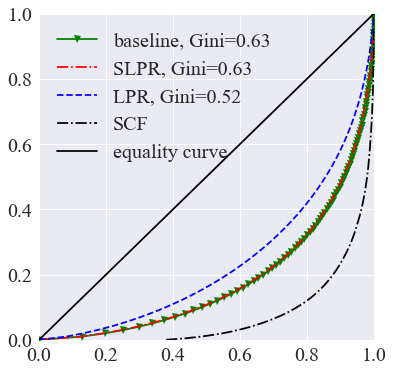

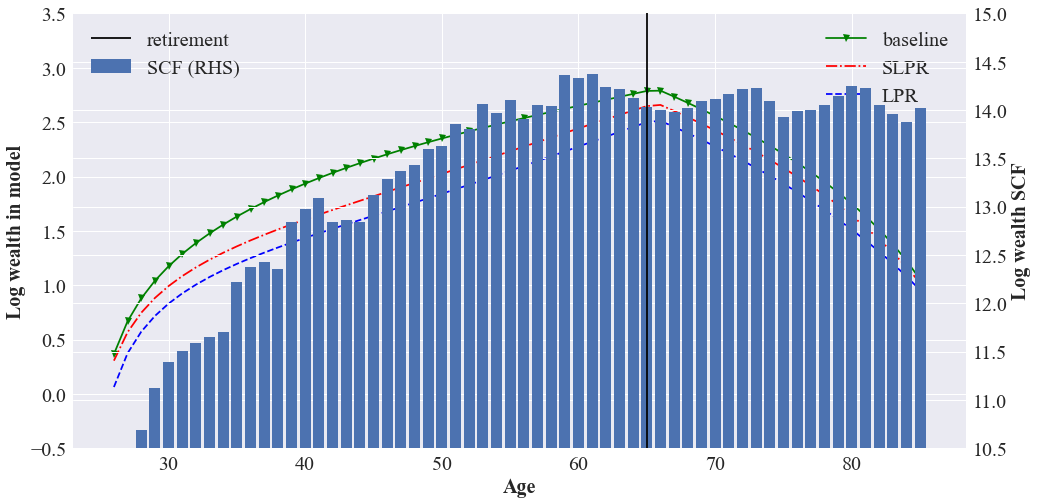

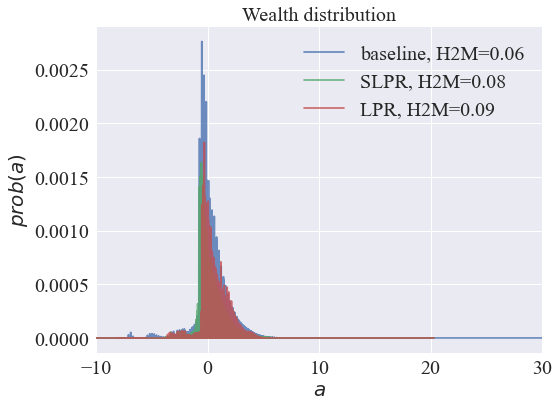

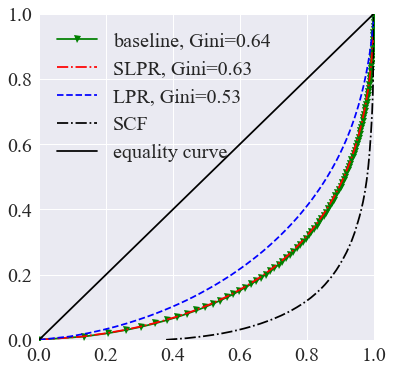

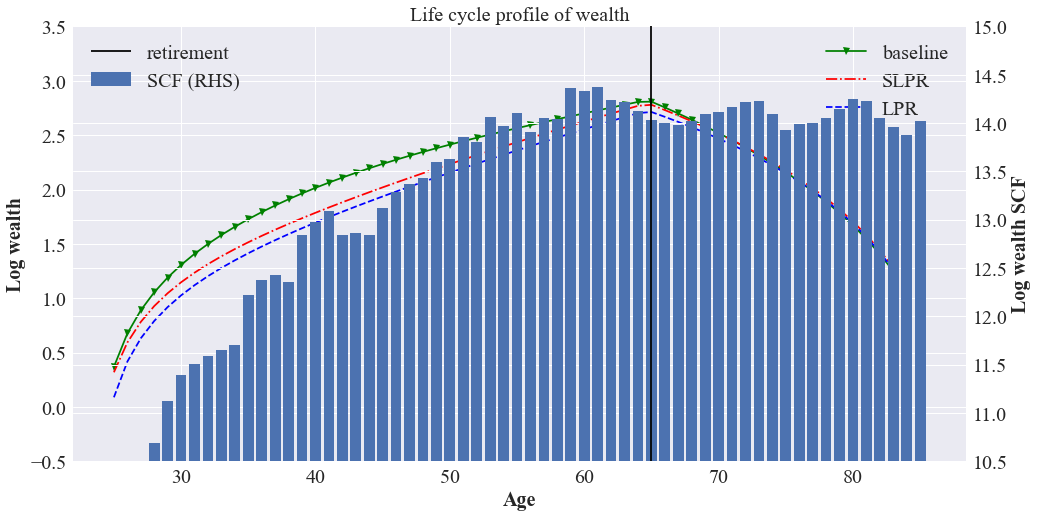

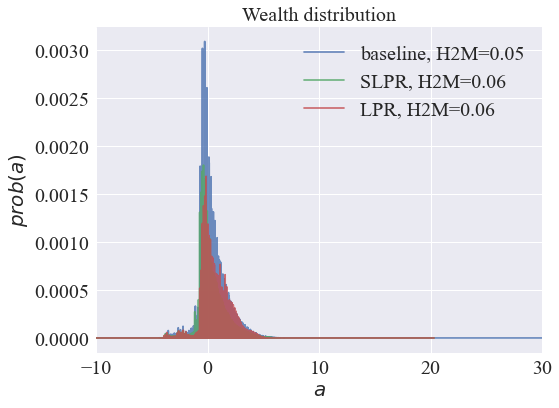

In [22]:
## plot results from different models

model_names=['baseline',
             'SLPR',
             'LPR',
             ]

line_patterns =['g-v',
                'r-.',
                'b--',
                ]

## Lorenz curve of steady state wealth distribution

fig, ax = plt.subplots(figsize=(6,6))
for k,model in enumerate(models):
    model_solution = pickle.load(open('./model_solutions/'+ model_names[k]+'_PE.pkl','rb'))
    ax.plot(model_solution['share_agents_ap'],
            model_solution['share_ap'],
            line_patterns[k],
            label = model_names[k]+', Gini={:.2f}'.format(model_solution['gini']))
ax.plot(SCF_share_agents_ap,
        SCF_share_ap, 'k-.',
        label='SCF')
ax.plot(model_solution['share_agents_ap'],
        model_solution['share_agents_ap'], 
        'k-',
        label='equality curve')
ax.legend()
plt.xlim([0,1])
plt.ylim([0,1])
#plt.savefig('../Graphs/model/lorenz_a_compare_pe.png')


## life cycle

age_lc = SCF_profile.index

fig, ax = plt.subplots(figsize=(16,8))
#plt.title('Life cycle profile of wealth')

for k,model in enumerate(models):
    model_solution = pickle.load(open('./model_solutions/'+ model_names[k]+'_PE.pkl','rb'))
    ax.plot(age_lc[1:],
           np.log(model_solution['A_life']),
           line_patterns[k],
           label= model_names[k])
ax.set_ylim([-0.5,3.5])

ax2 = ax.twinx()
ax2.set_ylim([10.5,15])
ax2.vlines(lc_mkv.T+25,
          10.5,
          15,
          color='k',
          label='retirement'
         )
ax2.bar(age_lc[1:],
        np.log(SCF_profile['mv_wealth'][1:]),
       label='SCF (RHS)')

ax.set_xlabel('Age')
ax.set_ylabel('Log wealth in model')
ax2.set_ylabel('Log wealth SCF')
ax.legend(loc=1)
ax2.legend(loc=2)
#fig.savefig('../Graphs/model/life_cycle_a_compare_pe.png')



## wealth distributions in pe

fig, ax = plt.subplots(figsize=(8,6))
ax.set_title('Wealth distribution')
for k, model in enumerate(models):
    model_solution = pickle.load(open('./model_solutions/'+ model_names[k]+'_PE.pkl','rb'))
    
    ## get h2m fraction: an arbitrary definition for now. a2p ratio smaller than 5 
    h2m_pe_where = np.where(model_solution['a_grid_dist']<=0.5)
    h2m_share =model_solution['a_pdfs_dist'][h2m_pe_where].sum()

    ax.plot(np.log(model_solution['ap_grid_dist']+1e-5),
            model_solution['ap_pdfs_dist'],
            label=model_names[k]+', H2M={:.2f}'.format(h2m_share),
           alpha = 0.8)
ax.set_xlabel(r'$a$')
ax.legend(loc=0)
ax.set_xlim([-10,30])


ax.set_ylabel(r'$prob(a)$')

#fig.savefig('../Graphs/model/distribution_a_compare_pe.png')


## lorenz curve in ge

fig, ax = plt.subplots(figsize=(6,6))
for k,model in enumerate(models):
    model_solution = pickle.load(open('./model_solutions/'+ model_names[k]+'_GE.pkl','rb'))
    ax.plot(model_solution['share_agents_ap'],
            model_solution['share_ap'],
            line_patterns[k],
            label = model_names[k]+', Gini={:.2f}'.format(model_solution['gini']))

ax.plot(SCF_share_agents_ap,
        SCF_share_ap, 'k-.',
        label='SCF')
ax.plot(model_solution['share_agents_ap'],
        model_solution['share_agents_ap'], 
        'k-',
        label='equality curve')
ax.legend()
plt.xlim([0,1])
plt.ylim([0,1])
#fig.savefig('../Graphs/model/lorenz_a_compare_ge.png')


## life cycle profile in ge

fig, ax = plt.subplots(figsize=(16,8))
plt.title('Life cycle profile of wealth')

for k, model in enumerate(models):
    model_solution = pickle.load(open('./model_solutions/'+ model_names[k]+'_GE.pkl','rb'))
    ax.plot(age_lc[:-2],
            np.log(model_solution['A_life'])[:-1],
            line_patterns[k],
           label = model_names[k])

ax.set_ylim([-0.5,3.5])

ax2 = ax.twinx()
ax2.set_ylim([10.5,15])
ax2.vlines(lc_mkv.T+25,
          10.5,
          15,
          color='k',
          label='retirement')
ax2.bar(age_lc,
        np.log(SCF_profile['mv_wealth']),
       #'k--',
       label='SCF (RHS)')

ax.set_xlabel('Age')
ax.set_ylabel('Log wealth')
ax2.set_ylabel('Log wealth SCF')
ax.legend(loc=1)
ax2.legend(loc=2)
#fig.savefig('../Graphs/model/life_cycle_a_compare_ge.png')


## wealth distributions in ge

fig, ax = plt.subplots(figsize=(8,6))
ax.set_title('Wealth distribution')
for k, model in enumerate(models):
    model_solution = pickle.load(open('./model_solutions/'+ model_names[k]+'_GE.pkl','rb'))
    
    ## get h2m fraction: an arbitrary definition for now. a2p ratio smaller than 5 
    h2m_ge_where = np.where(model_solution['a_grid_dist']<=0.5)
    h2m_share =model_solution['a_pdfs_dist'][h2m_ge_where].sum()

    ax.plot(np.log(model_solution['ap_grid_dist']+1e-5),
            model_solution['ap_pdfs_dist'],
            label=model_names[k]+', H2M={:.2f}'.format(h2m_share),
            alpha = 0.8)
ax.set_xlabel(r'$a$')
ax.legend(loc=0)
ax.set_ylabel(r'$prob(a)$')
ax.set_xlim([-10,30])


#fig.savefig('../Graphs/model/distribution_a_compare_ge.png')
